# ADS 599 Team 7 Final Project

## Image Classification For Pneumonia Detection using Chest X-Ray Images

#### University of San Diego - Applied Data Science
#### Chow, Eva
#### Duan, Dingyi 
#### Tan, Abby

#### Github Link: https://github.com/dingyiduan7/ADS599_Capstone_Image_Recognition

### Load the necessary packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from random import randint

from scipy import ndimage

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from tensorflow import keras  
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, MaxPooling2D, Activation, Input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import classification_report,confusion_matrix

## Stage 1: Data Loading and Exploratory Data Analysis (EDA)

Display all our datasets/folders

In [3]:
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray"))
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/train"))
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/val"))
print(os.listdir("D:/USD-ADS_graduate/ADS-599/chest_xray/test"))

Here we have three folders of train, val and test sets.
Each folder contains two subfolders of "NORMAL" and "PNEUMONIA" images.

In [4]:
# set the path for all three datasets
data_dir = Path("D:/USD-ADS_graduate/ADS-599/chest_xray/")
train_dir = data_dir/"train"
val_dir = data_dir/"val"
test_dir = data_dir/"test"

In [5]:
# set the path for all three datasets
# data_dir = Path("C:/Users/abby0/OneDrive/Desktop/MSADS/ADS-599 Capstone/Project/chest_xray/")
# train_dir = data_dir/"train"
# val_dir = data_dir/"val"
# test_dir = data_dir/"test"

In [6]:
# function to load the data into dataframes from each folder and label them

def load_data(data_path):
    normal_dir = data_path/"NORMAL"
    pneum_dir = data_path/"PNEUMONIA"
    
    # images are in .jpeg format
    normal_img = normal_dir.glob('*.jpeg')
    pneum_img = pneum_dir.glob('*.jpeg')
    
    img_data = []
    img_label = []
    
    for img in normal_img:
        img_data.append(img)
        img_label.append('NORMAL')
        
    for img in pneum_img:
        img_data.append(img)
        img_label.append('PNEUMONIA')
    df = pd.DataFrame(img_data,columns=['images'])
    df['label'] = img_label
    df = df.reset_index(drop=True)
    
    return df

In [7]:
df_train = load_data(train_dir)
print(df_train.sample(10))

                                                 images      label
1316  C:\Users\abby0\OneDrive\Desktop\MSADS\ADS-599 ...     NORMAL
2650  C:\Users\abby0\OneDrive\Desktop\MSADS\ADS-599 ...  PNEUMONIA
1946  C:\Users\abby0\OneDrive\Desktop\MSADS\ADS-599 ...  PNEUMONIA
3548  C:\Users\abby0\OneDrive\Desktop\MSADS\ADS-599 ...  PNEUMONIA
5091  C:\Users\abby0\OneDrive\Desktop\MSADS\ADS-599 ...  PNEUMONIA
2747  C:\Users\abby0\OneDrive\Desktop\MSADS\ADS-599 ...  PNEUMONIA
2056  C:\Users\abby0\OneDrive\Desktop\MSADS\ADS-599 ...  PNEUMONIA
1878  C:\Users\abby0\OneDrive\Desktop\MSADS\ADS-599 ...  PNEUMONIA
2133  C:\Users\abby0\OneDrive\Desktop\MSADS\ADS-599 ...  PNEUMONIA
3822  C:\Users\abby0\OneDrive\Desktop\MSADS\ADS-599 ...  PNEUMONIA


Create all the dataframes seprately to avoid data leakage

In [8]:
df_val = load_data(val_dir)
df_test = load_data(test_dir)
print('The training data has a shape of:',df_train.shape)
print('The validate data has a shape of:',df_val.shape)
print('The test data has a shape of:',df_test.shape)

The training data has a shape of: (5216, 2)
The validate data has a shape of: (16, 2)
The test data has a shape of: (624, 2)


Let's check to see whether the training set is balanced.

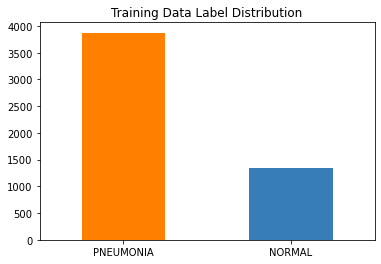

In [9]:
# using colorblind friendly colors
df_train['label'].value_counts().plot(kind='bar',rot=0,title="Training Data Label Distribution",color=['#ff7f00','#377eb8'])

As many real life problems, our training data is obviously imbalanced. We could perform oversampling to balance the dataset.

In [10]:
# Oversampling
df_train['images'][0]

WindowsPath('C:/Users/abby0/OneDrive/Desktop/MSADS/ADS-599 Capstone/Project/chest_xray/train/NORMAL/IM-0115-0001.jpeg')

We can also look at our images to see how different are normal and pneumonia on x-ray

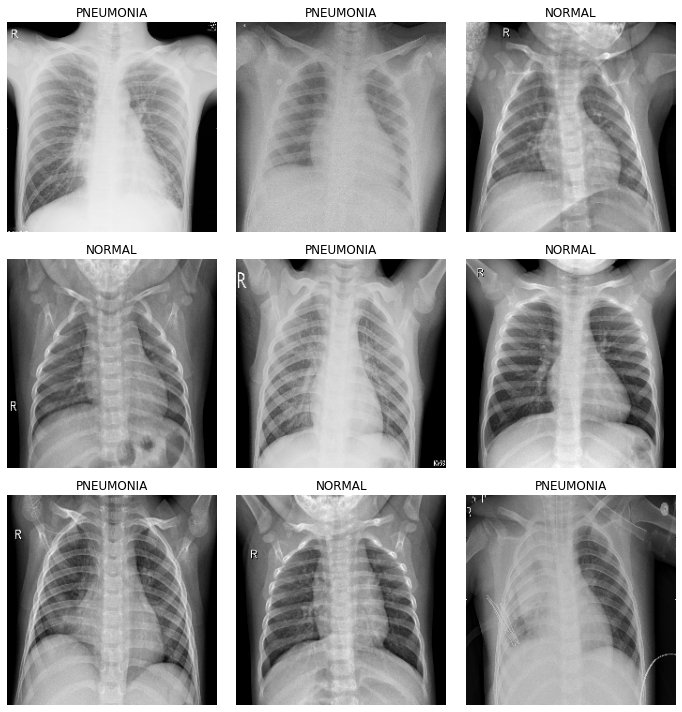

In [11]:
plt.figure(figsize=(10,10))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    j = randint(0, len(df_train))
    img_path = str(df_train['images'][j])
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224))
    plt.title(df_train['label'][j])
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()

From the raw images we can see that it can be hard for our bare eyes to tell the difference.

## Stage 2: Data Cleaning and Preprocessing

### Image Formatting/ Image Augmentation


Reference: https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/

Let's take a random sample from our training set and look at how different image formatting and augmentation will take effect on our images.

(-0.5, 223.5, 223.5, -0.5)

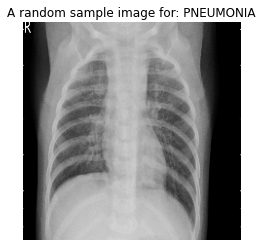

In [12]:
sample_ind = randint(0, len(df_train))
sample_path= str(df_train['images'][sample_ind])
sample_img = cv2.imread(sample_path)
sample_img = cv2.resize(sample_img,(224,224))
plt.title('A random sample image for: %s'%df_train['label'][sample_ind])
plt.imshow(sample_img)
plt.axis('off')

In [13]:
def original(img):
    return img

#### 1. Resizing 
Resize the image to a given length and width

In [14]:
def resizing(img):
    res_img = cv2.resize(img, (50,50)) # using 300 as an arbitrary dimension
    return res_img

#### 2. Gray Scaling
The image will be converted to gray scale (range of gray shades from white to black) the computer will assign each pixel a value based on how dark it is. All the numbers are put into an array and the computer does computations on that array.

In [15]:
def gray_scale(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

#### 3. Reflection/Flip
flip images horizontally and vertically. Some frameworks do not provide function for vertical flips. But, a vertical flip is equivalent to rotating an image by 180 degrees and then performing a horizontal flip.

In [16]:
def ref_flip(img):
    flip_img = cv2.flip(img,1)
    return flip_img

#### 4. Gaussian Blurring
Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise.

In [17]:
def gau_blur(img):
    blur_img = ndimage.gaussian_filter(img, sigma= 5.11)
    return blur_img

#### 5. Histogram Equalization
Histogram equalization is another image processing technique to increase global contrast of an image using the image intensity histogram. This method needs no parameter, but it sometimes results in an unnatural looking image.

In [18]:
def hist_eq(img):
    img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
    hist_img= cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_img

#### 6. Rotation
Rotating an image might not preserve its original dimensions (depending on what angle you choose to rotate it with )

In [19]:
def rotation(img):
    rows,cols = img.shape[0],img.shape[1]
    randDeg = random.randint(-180, 180)
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), randDeg, 0.70)
    rot_img = cv2.warpAffine(img, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT)
    return rot_img 

#### 7. Channel Conversion
Some images are in  greyscale (1 channel), therefore convert them to 3 channel

In [20]:
def channel_con(img):
    if img.shape[2]==1:
        img = dstack([img,img,img])
    return img 

#### 8. Color Conversion
Images read using cv2 are in BGR format(by default), convert it to RGB.

In [21]:
def color_con(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

There we have it, a series of image augmentation and processing that enables us to modify the images for training to improve the model performance.
#### Augmentation Comparison

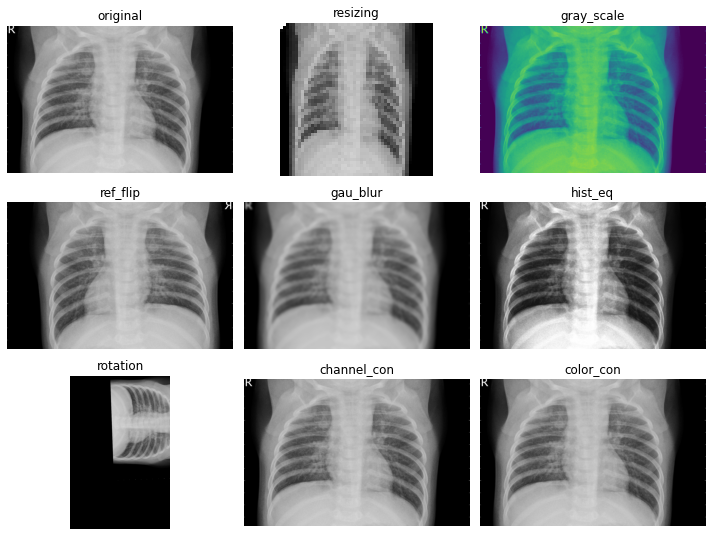

In [22]:
img_aug = [original, resizing, gray_scale, ref_flip, gau_blur, hist_eq, rotation, channel_con, color_con]

plt.figure(figsize=(10,10))
for aug in img_aug:
    ax = plt.subplot(4,3,img_aug.index(aug)+1)
    sample_img = cv2.imread(sample_path)
    sample_img = aug(sample_img)
    plt.title(aug.__name__)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.tight_layout()   

From the comparison we can see that:

- resizing changes the pixel amount of the images, causing it to be higher or lower resolved;
- grey scaling is to make sure our images have one channel.
- relection/flip is also unnecessary since the x-ray images has a "right" reference, it may be harmful for our predictions;
- gaussion blurrying doesn't seem to help us neither by blurring the images;
- histogram equalization increases the constrast of our images, but also changes the color channel to 3.
- rotation causes the disortion of our image size and quality, may not be useful for us
- channel conversion is not needed since our grey scaled x-rays already has one channel in them.
- color conversion does not cause an impact on our images but it is nice to make sure they all has the same channel order.

#### Image when all augmentation is performed.

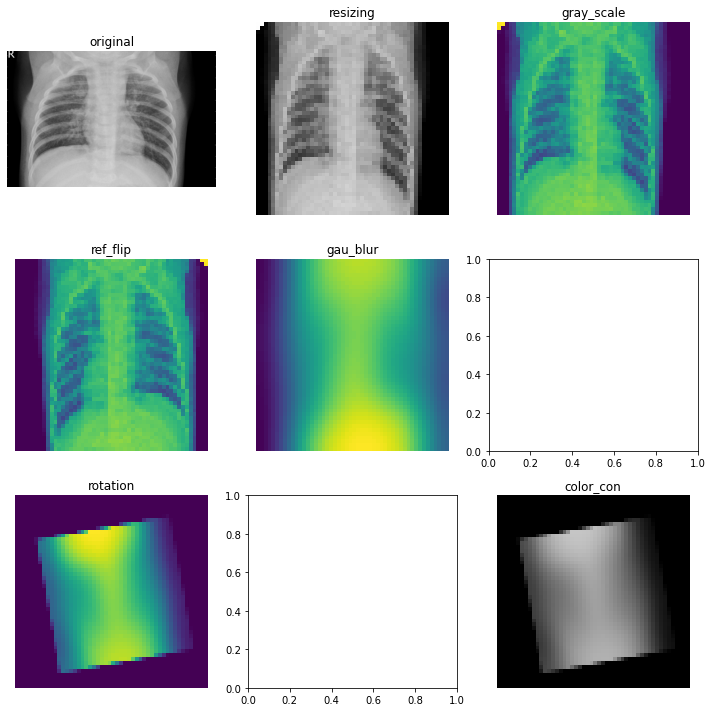

In [23]:
img_aug = [original, resizing, gray_scale, ref_flip, gau_blur, hist_eq, rotation, channel_con, color_con]
sample_img = cv2.imread(sample_path)
plt.figure(figsize=(10,10))
for aug in img_aug:
    try:
        ax = plt.subplot(3,3,img_aug.index(aug)+1)
        sample_img = aug(sample_img)
        plt.title(aug.__name__)
        plt.imshow(sample_img)
        plt.axis('off')
        plt.tight_layout()  
    except:
        pass

Obviously we cannot perform all processing steps to the same image all together, it is only rational for us to find the most optimal way to prepare the image.

Let's try with the following augmentation:
- resizing to 224 x 224
- gray scaling
- histogram equalization

In [24]:
# we'll resize the image to better quality
def resizing2(img):
    res_img = cv2.resize(img, (224,224)) # using 224 for better pixel size
    return res_img

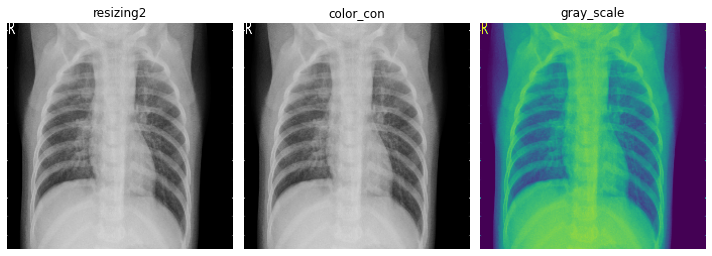

In [25]:
img_aug = [resizing2, color_con, gray_scale,]
sample_img = cv2.imread(sample_path)
plt.figure(figsize=(10,10))
for aug in img_aug:
    ax = plt.subplot(1, 3, img_aug.index(aug)+1)
    sample_img = aug(sample_img)
    plt.title(aug.__name__)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.tight_layout()   

This would be a better processing procedure, hence we set our pipeline to be such.

In [26]:
# pipeline implementation
def prepare(path, pipeline) : 
    img = cv2.imread(str(path))
    
    for transform in pipeline : 
        img = transform(img)
        
    return img

pipeline = [resizing2, color_con, gray_scale]

### Training data

In [27]:
df_train['images'] = df_train['images'].apply(prepare,pipeline = pipeline)

In [28]:
df_train.head()

,images,label
0,"[[24, 20, 19, 17, 17, 28, 56, 58, 64, 65, 72, ...",NORMAL
1,"[[14, 24, 25, 31, 34, 37, 36, 43, 47, 45, 49, ...",NORMAL
2,"[[0, 0, 0, 8, 18, 27, 32, 35, 44, 45, 50, 57, ...",NORMAL
3,"[[40, 46, 47, 55, 55, 58, 61, 69, 73, 78, 81, ...",NORMAL
4,"[[77, 77, 62, 57, 50, 39, 29, 28, 28, 25, 20, ...",NORMAL


In [29]:
for i in range(len(df_train)):
    df_train['images'][i] = df_train['images'][i].astype(np.float32)/255
    
df_train['label'] = df_train['label'].astype(str)
df_train['label'] = df_train['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [30]:
df_train.sample(20)

,images,label
320,"[[0.02745098, 0.0627451, 0.08627451, 0.1098039...",0
2153,"[[0.11764706, 0.12156863, 0.12156863, 0.117647...",1
745,"[[0.13333334, 0.13333334, 0.13333334, 0.141176...",0
2595,"[[0.12941177, 0.16862746, 0.18039216, 0.2, 0.2...",1
145,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2611,"[[0.10980392, 0.105882354, 0.12156863, 0.12941...",1
5028,"[[0.08235294, 0.09019608, 0.08235294, 0.098039...",1
1685,"[[0.0, 0.007843138, 0.050980393, 0.105882354, ...",1
4210,"[[0.047058824, 0.043137256, 0.039215688, 0.035...",1
202,"[[0.38039216, 0.37254903, 0.3647059, 0.4078431...",0


In [31]:
x_train = np.array([df_train['images'][i] for i in range(len(df_train))])
y_train = np.array(df_train['label'])

##### Reshape data for model without sequential (2 dimension)

Train dataset consists 5216 images, and each image was resize to 224 x 224 pixels, which implies each image in the dataset is represented by 224 x 224 = 50,176 integers.

In [32]:
x_train.shape

(5216, 224, 224)

In [33]:
x_train_2dim = x_train.reshape((x_train.shape[0], 50176))

In [34]:
print(pd.DataFrame(x_train_2dim).shape)
pd.DataFrame(x_train_2dim).head(3)

(5216, 50176)


,0,1,2,3,4,5,6,7,8,9,...,50166,50167,50168,50169,50170,50171,50172,50173,50174,50175
0,0.094118,0.078431,0.074510,0.066667,0.066667,0.109804,0.219608,0.227451,0.250980,0.254902,...,0.407843,0.415686,0.419608,0.419608,0.427451,0.427451,0.435294,0.423529,0.443137,0.431373
1,0.054902,0.094118,0.098039,0.121569,0.133333,0.145098,0.141176,0.168627,0.184314,0.176471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.031373,0.070588,0.105882,0.125490,0.137255,0.172549,0.176471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765


In [35]:
le = LabelEncoder()
y_train_2dim = le.fit_transform(df_train['label'])

##### Reshape data for deep learning models (4 dimension)

In [36]:
x_train_4dim = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
y_train_4dim = tf.keras.utils.to_categorical(y_train, 3)

### Validation data

In [37]:
df_val['images'] = df_val['images'].apply(prepare,pipeline=pipeline)

In [38]:
for i in range(len(df_val)):
    df_val['images'][i] = df_val['images'][i].astype(np.float32)/255
    
df_val['label'] = df_val['label'].astype(str)
df_val['label'] = df_val['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [39]:
x_val = np.array([df_val['images'][i] for i in range(len(df_val))])
y_val = np.array(df_val['label'])

##### Reshape Validate Data for model without sequential (2 dimension)

In [40]:
x_val_2dim = x_val.reshape((x_val.shape[0], 50176))
y_val_2dim = le.fit_transform(df_val['label'])

##### Reshape data for deep learning models (4 dimension)

In [41]:
x_val_4dim = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
y_val_4dim = tf.keras.utils.to_categorical(y_val, 3)

### Test data

In [42]:
df_test['images'] = df_test['images'].apply(prepare,pipeline=pipeline)

In [43]:
for i in range(len(df_test)):
    df_test['images'][i] = df_test['images'][i].astype(np.float32)/255
    
df_test['label'] = df_test['label'].astype(str)
df_test['label'] = df_test['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [44]:
x_test = np.array([df_test['images'][i] for i in range(len(df_test))])
y_test = np.array(df_test['label'])

##### Reshape Test Data for model without sequential (2 dimension)

In [45]:
x_test_2dim = x_test.reshape((x_test.shape[0], 50176))
y_test_2dim = le.fit_transform(df_test['label'])

##### Reshape data for deep learning models (4 dimension)

In [46]:
x_test_4dim = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test_4dim = tf.keras.utils.to_categorical(y_test, 3)

## Stage 3: Model Definition and Training

### Sequential Setup

In [47]:
model = Sequential()
model.add(Conv2D(16,(5,5), padding='valid',input_shape = (224, 224, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.4))
model.add(Conv2D(32,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.6))
model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      416       
                                                                 
 activation (Activation)     (None, 220, 220, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 activation_1 (Activation)   (None, 106, 106, 32)      0         
                                                        

In [49]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

20/20 [==============================] - 2s 93ms/step


### General Macine Learning Classifiers

##### SVM

In [50]:
svm = SVC(kernel='rbf')
svm.fit(feat_train,y_train)
svm.score(feat_test,y_test)

0.625

In [51]:
cm_svm_1 = confusion_matrix(y_test, svm.predict(feat_test))

Without sequential 

In [52]:
svm = SVC(kernel='rbf')
svm.fit(x_train_2dim,y_train_2dim)
svm.score(x_test_2dim,y_test_2dim)

0.7580128205128205

In [53]:
cm_svm_2 = confusion_matrix(y_test_2dim, svm.predict(x_test_2dim))

##### KNN

In [54]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

20/20 [==============================] - 2s 99ms/step


In [55]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(feat_train,y_train)
knn.score(feat_test,y_test)

0.6346153846153846

In [56]:
cm_knn_1 = confusion_matrix(y_test, knn.predict(feat_test))

Without sequential 

In [57]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(x_train_2dim,y_train_2dim)
knn.score(x_test_2dim,y_test_2dim)

0.7403846153846154

In [58]:
cm_knn_2 = confusion_matrix(y_test_2dim, knn.predict(x_test_2dim))

##### Decision Tree

In [59]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

20/20 [==============================] - 2s 97ms/step


In [60]:
dt = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=5, min_samples_leaf=5)
dt.fit(feat_train,y_train)
dt.score(feat_test,y_test)

0.6298076923076923

In [61]:
cm_dt_1 = confusion_matrix(y_test, dt.predict(feat_test))

Without sequential 

In [62]:
dt = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=5, min_samples_leaf=5)
dt.fit(x_train_2dim,y_train_2dim)
dt.score(x_test_2dim,y_test_2dim)

0.7227564102564102

In [63]:
cm_dt_2 = confusion_matrix(y_test_2dim, dt.predict(x_test_2dim))

##### Random Forest

In [64]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

20/20 [==============================] - 2s 96ms/step


In [65]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(feat_train,y_train)
rf.score(feat_test,y_test)

0.6217948717948718

In [66]:
cm_rf_1 = confusion_matrix(y_test, rf.predict(feat_test))

Without sequential 

In [67]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(x_train_2dim,y_train_2dim)
rf.score(x_test_2dim,y_test_2dim)

0.7564102564102564

In [68]:
cm_rf_2 = confusion_matrix(y_test_2dim, rf.predict(x_test_2dim))

### Deep Learning Models

In [69]:
datagen = ImageDataGenerator(
              rotation_range = 0,  
              zoom_range = 0, 
              width_shift_range = 0, 
              height_shift_range = 0)

In [70]:
datagen.fit(x_train_4dim)
train_gen_cnn = datagen.flow(x_train_4dim, y_train_4dim, batch_size=32)

In [71]:
datagen.fit(x_test_4dim)
test_gen_cnn = datagen.flow(x_test_4dim, y_test_4dim, batch_size=32)

##### CNN

In [72]:
input1 = Input(shape=(x_train_4dim.shape[1], x_train_4dim.shape[2], 1))
cnn = Sequential()

cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = keras.Model(inputs=input1, outputs=output1)

In [73]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      160       
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 16)      2064      
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 32)      2080      
                                                           

# ** please change steps_per_epoch & epochs to higher frequencies here **

In [74]:
history_cnn = model.fit_generator(train_gen_cnn, validation_data=test_gen_cnn, steps_per_epoch=50, epochs=2)

Epoch 1/2
50/50 [==============================] - 49s 980ms/step - loss: 0.4162 - acc: 0.8062 - val_loss: 0.3189 - val_acc: 0.8750
Epoch 2/2
50/50 [==============================] - 49s 975ms/step - loss: 0.1492 - acc: 0.9469 - val_loss: 0.3492 - val_acc: 0.8590


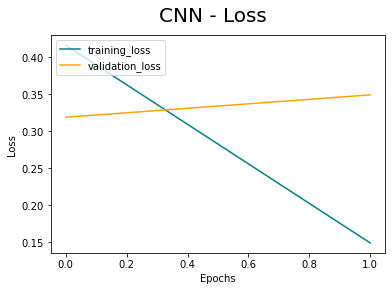

In [75]:
fig = plt.figure()
plt.plot(history_cnn.history['loss'], color='teal', label='training_loss')
plt.plot(history_cnn.history['val_loss'], color='orange', label='validation_loss')
fig.suptitle('CNN - Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

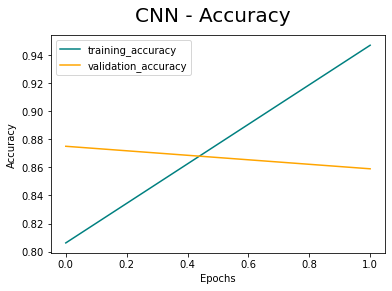

In [76]:
fig = plt.figure()
plt.plot(history_cnn.history['acc'], color='teal', label='training_accuracy')
plt.plot(history_cnn.history['val_acc'], color='orange', label='validation_accuracy')
fig.suptitle('CNN - Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [77]:
cm_cnn = confusion_matrix(
                np.concatenate([np.argmax(test_gen_cnn[i][1], axis=1) for i in range(len(test_gen_cnn))]),    
                np.argmax(model.predict_generator(test_gen_cnn, steps=len(test_gen_cnn)), axis=1) 
                         )

##### vgg16

Reference: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [78]:
x_train_vgg16 = x_train_4dim.copy()
x_test_vgg16 = x_test_4dim.copy()

In [79]:
y_train_vgg16 = np.asarray(y_train_2dim).astype('float32').reshape((-1,1))
y_test_vgg16 = np.asarray(y_test_2dim).astype('float32').reshape((-1,1))

In [80]:
datagen.fit(x_train_vgg16)
train_gen_vgg16 = datagen.flow(x_train_vgg16, y_train_vgg16, batch_size=32)

In [81]:
datagen.fit(x_test_vgg16)
test_gen_vgg16 = datagen.flow(x_test_vgg16, y_test_vgg16, batch_size=32)

In [82]:
base_model = VGG16(input_shape = (224, 224, 1),
                   include_top = False,
                   weights = None)

In [83]:
for layer in base_model.layers:
    layer.trainable = False

In [84]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# ** please change steps_per_epoch & epochs to higher frequencies here **

In [85]:
history_vgghist = model.fit(train_gen_vgg16, validation_data = test_gen_vgg16, steps_per_epoch = 50, epochs = 2)

Epoch 1/2
50/50 [==============================] - 200s 4s/step - loss: 0.6496 - acc: 0.7194 - val_loss: 0.6718 - val_acc: 0.6250
Epoch 2/2
50/50 [==============================] - 203s 4s/step - loss: 0.5969 - acc: 0.7456 - val_loss: 0.6862 - val_acc: 0.6250


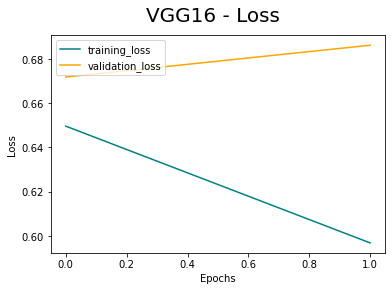

In [86]:
fig = plt.figure()
plt.plot(history_vgghist.history['loss'], color='teal', label='training_loss')
plt.plot(history_vgghist.history['val_loss'], color='orange', label='validation_loss')
fig.suptitle('VGG16 - Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

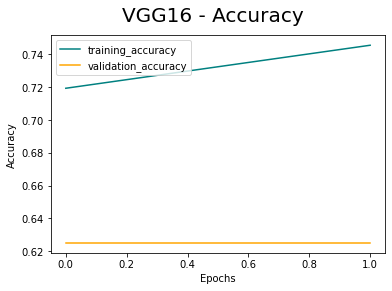

In [87]:
fig = plt.figure()
plt.plot(history_vgghist.history['acc'], color='teal', label='training_accuracy')
plt.plot(history_vgghist.history['val_acc'], color='orange', label='validation_accuracy')
fig.suptitle('VGG16 - Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [88]:
# need revision - true labels only extracted "0" values (missing "1")
cm_vgg16 = confusion_matrix(
                np.concatenate([np.argmax(test_gen_vgg16[i][1], axis=1) for i in range(len(test_gen_vgg16))]),    
                np.argmax(model.predict_generator(test_gen_vgg16, steps=len(test_gen_vgg16)), axis=1) 
                         )

##### ResNet50

Reference: https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38

In [89]:
x_train_resnet = x_train_vgg16.copy()
x_test_resnet = x_test_vgg16.copy()

y_train_resnet = y_train_vgg16.copy()
y_test_resnet = y_test_vgg16.copy()

In [90]:
datagen.fit(x_train_resnet)
train_gen_resnet = datagen.flow(x_train_resnet, y_train_resnet, batch_size=32)

In [91]:
datagen.fit(x_train_resnet)
test_gen_resnet = datagen.flow(x_train_resnet, y_train_resnet, batch_size=32)

In [92]:
from tensorflow.keras.applications import ResNet50
from keras.models import Model
import keras
restnet = ResNet50(include_top=False, weights=None, input_shape=(224,224,1))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output)

In [93]:
for layer in restnet.layers:
    layer.trainable = False

In [94]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=(224,224,1)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, 100352)            23581440  
                                                                 
 dense_6 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 513       
                                                                 
Total params: 75,225,345
Trainable params: 51,643,905


# ** please change steps_per_epoch & epochs to higher frequencies here **

In [95]:
history_resnet = model.fit_generator(train_gen_resnet, validation_data=test_gen_resnet, steps_per_epoch=50, epochs=2)

Epoch 1/2
50/50 [==============================] - 287s 6s/step - loss: 0.5703 - acc: 0.7425 - val_loss: 0.5477 - val_acc: 0.7429
Epoch 2/2
50/50 [==============================] - 282s 6s/step - loss: 0.5392 - acc: 0.7425 - val_loss: 0.5126 - val_acc: 0.7429


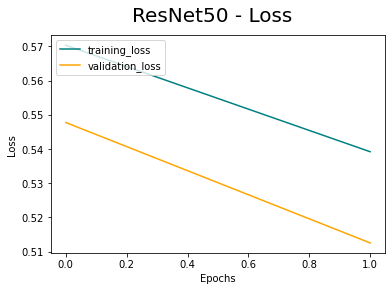

In [96]:
fig = plt.figure()
plt.plot(history_resnet.history['loss'], color='teal', label='training_loss')
plt.plot(history_resnet.history['val_loss'], color='orange', label='validation_loss')
fig.suptitle('ResNet50 - Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

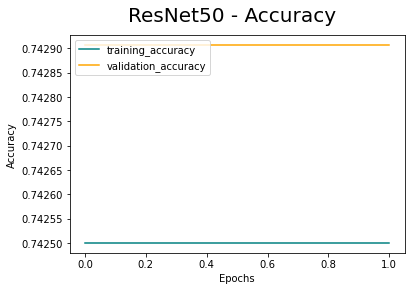

In [97]:
fig = plt.figure()
plt.plot(history_resnet.history['acc'], color='teal', label='training_accuracy')
plt.plot(history_resnet.history['val_acc'], color='orange', label='validation_accuracy')
fig.suptitle('ResNet50 - Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [98]:
# need revision - true labels only extracted "0" values (missing "1")
cm_resnet = confusion_matrix(
                np.concatenate([np.argmax(test_gen_resnet[i][1], axis=1) for i in range(len(test_gen_resnet))]),    
                np.argmax(model.predict_generator(test_gen_resnet, steps=len(test_gen_resnet)), axis=1) 
                         )

## Stage 4: Model performance and evaluation

### Confusion Matrix

##### SVM

In [99]:
cm_svm_1

array([[  0, 234],
       [  0, 390]], dtype=int64)

In [100]:
cm_svm_2

array([[ 88, 146],
       [  5, 385]], dtype=int64)

##### KNN

In [101]:
cm_knn_1

array([[ 32, 202],
       [ 26, 364]], dtype=int64)

In [102]:
cm_knn_2

array([[ 75, 159],
       [  3, 387]], dtype=int64)

##### Decision Tree

In [103]:
cm_dt_1

array([[  7, 227],
       [  4, 386]], dtype=int64)

In [104]:
cm_dt_2

array([[ 98, 136],
       [ 37, 353]], dtype=int64)

##### Random Forest

In [105]:
cm_rf_1

array([[ 35, 199],
       [ 37, 353]], dtype=int64)

In [106]:
cm_rf_2

array([[ 85, 149],
       [  3, 387]], dtype=int64)

##### CNN

In [107]:
cm_cnn

array([[169,  65],
       [ 23, 367]], dtype=int64)

##### vgg16

In [108]:
cm_vgg16

array([[624]], dtype=int64)

##### ResNet50

In [109]:
cm_resnet

array([[5216]], dtype=int64)

## Stage 5: Model Deployment